In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import matplotlib
import matplotlib.pyplot as plt
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
import itertools
from IPython.display import display

%matplotlib inline


In [3]:
x_train = pd.read_csv('/home/rashmi/BE Project/pre-processed/s2e/audio_train.csv')
x_test = pd.read_csv('/home/rashmi/BE Project/pre-processed/s2e/audio_test.csv')

print(x_train.shape)
y_train = x_train['label']
y_test = x_test['label']

(1704, 10)


In [4]:
print(x_train.shape, x_test.shape)
cl_weight = dict(pd.Series(x_train['label']).value_counts(normalize=True))
print(dict(pd.Series(x_train['label']).value_counts()))

del x_train['label']
del x_test['label']
del x_train['wav_file']
del x_test['wav_file']

(1704, 10) (426, 10)
{2: 508, 1: 357, 5: 297, 3: 242, 4: 165, 0: 135}


In [5]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

Test Set Accuracy =  0.538
Test Set F-score =  0.564
Test Set Precision =  0.585
Test Set Recall =  0.576
Confusion matrix, without normalization
[[11 15  7  0  0  2]
 [ 6 29 34  0  3 13]
 [ 3 35 69  1  3  7]
 [ 0  0  0 68  0  0]
 [ 0  0  0  0 33  0]
 [ 0 19 45  1  3 19]]


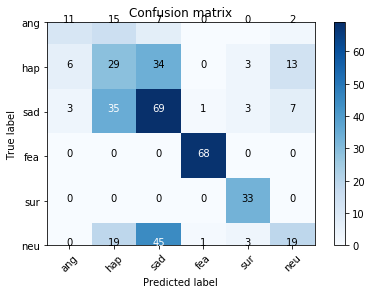

In [6]:
rf_classifier = RandomForestClassifier(n_estimators=1200, min_samples_split=25)
rf_classifier.fit(x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(x_test)
#print(pred_probs)
# Results
display_results(y_test, pred_probs)

with open('/home/rashmi/BE Project/pre-processed/pred_probas/rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.559
Test Set F-score =  0.584
Test Set Precision =  0.608
Test Set Recall =  0.583
Confusion matrix, without normalization
[[ 8 15  9  1  0  2]
 [ 5 33 34  0  0 13]
 [ 6 28 74  0  0 10]
 [ 0  0  0 68  0  0]
 [ 0  0  0  0 33  0]
 [ 1 15 48  1  0 22]]


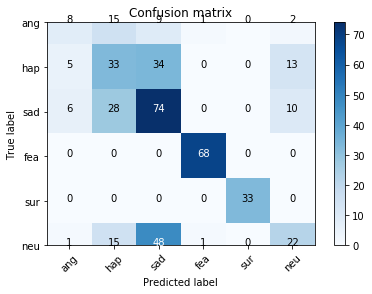

In [7]:
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                   n_estimators=1200, sub_sample=0.8, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('/home/rashmi/BE Project/pre-processed/pred_probas/xgb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.434
Test Set F-score =  0.420
Test Set Precision =  0.496
Test Set Recall =  0.402
Confusion matrix, without normalization
[[ 7 15  9  0  0  4]
 [ 3 36 28  2  3 13]
 [ 0 35 58  3  7 15]
 [ 0  5  0 50  0 13]
 [ 0  2 21  1  9  0]
 [ 0 12 40  7  3 25]]


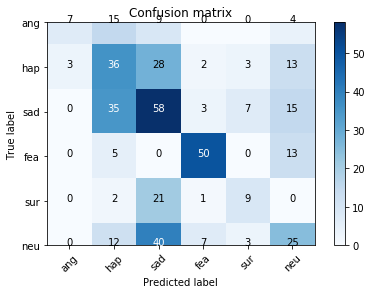

In [8]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(650, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.01,
                               power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.0001,
                               verbose=False, warm_start=True, momentum=0.8, nesterovs_momentum=True,
                               early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                               epsilon=1e-08)

mlp_classifier.fit(x_train, y_train)

# Predict
pred_probs = mlp_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('/home/rashmi/BE Project/pre-processed/pred_probas/mlp_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.434
Test Set F-score =  0.420
Test Set Precision =  0.496
Test Set Recall =  0.402
Confusion matrix, without normalization
[[ 7 15  9  0  0  4]
 [ 3 36 28  2  3 13]
 [ 0 35 58  3  7 15]
 [ 0  5  0 50  0 13]
 [ 0  2 21  1  9  0]
 [ 0 12 40  7  3 25]]


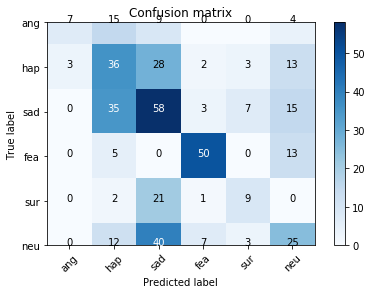

In [9]:
    svc_classifier = LinearSVC()

    svc_classifier.fit(x_train, y_train)

    # Predict
    pred = svc_classifier.predict(x_test)

    # Results
    display_results(y_test, pred_probs)

    with open('/home/rashmi/BE Project/pre-processed/pred_probas/svc_classifier_model.pkl', 'wb') as f:
        pickle.dump(svc_classifier, f)

Test Set Accuracy =  0.282
Test Set F-score =  0.086
Test Set Precision =  0.255
Test Set Recall =  0.173
Confusion matrix, without normalization
[[  1   3  31   0   0   0]
 [  0   1  84   0   0   0]
 [  0   0 118   0   0   0]
 [  0   0  68   0   0   0]
 [  0   0  33   0   0   0]
 [  0   0  87   0   0   0]]


/home/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


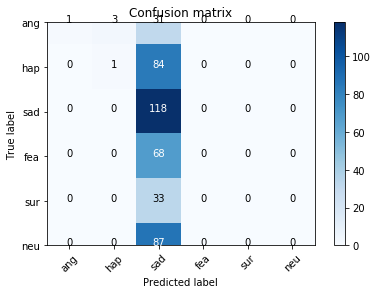

In [10]:
mnb_classifier = MultinomialNB()

mnb_classifier.fit(x_train, y_train)

# Predict
pred_probs = mnb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('/home/rashmi/BE Project/pre-processed/pred_probas/mnb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.286
Test Set F-score =  0.150
Test Set Precision =  0.207
Test Set Recall =  0.200
Confusion matrix, without normalization
[[  6  14  15   0   0   0]
 [  3  14  68   0   0   0]
 [  0  16 102   0   0   0]
 [  0   0  68   0   0   0]
 [  0   0  33   0   0   0]
 [  0   3  84   0   0   0]]


/home/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


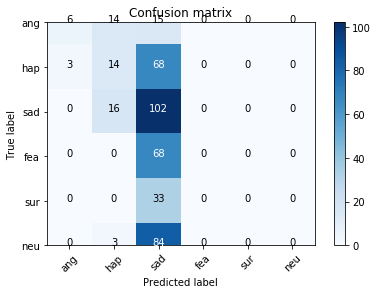

In [11]:
lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)

lr_classifier.fit(x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('/home/rashmi/BE Project/pre-processed/pred_probas/lr_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

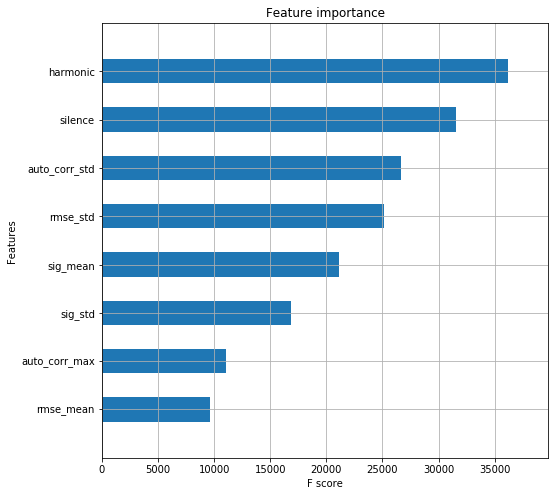

In [12]:
ax = xgb.plot_importance(xgb_classifier, max_num_features=10, height=0.5, show_values=False)
fig = ax.figure
fig.set_size_inches(8, 8)

In [13]:
contribution_scores = xgb_classifier.feature_importances_
contribution_scores

array([0.07551573, 0.11006521, 0.13307469, 0.12305584, 0.13055892,
       0.08024025, 0.22922629, 0.11826307], dtype=float32)

In [14]:
top_n = [3, 5, 6, 7, 8]  # number of features
for n in top_n:
    threshold = np.argsort(contribution_scores)[::-1][:n][-1]
    print('Stats for top {} features:'.format(n))
    # Select features using threshold
    selection = SelectFromModel(xgb_classifier, threshold=contribution_scores[threshold], prefit=True)
    select_x_train = selection.transform(x_train)
    select_x_test = selection.transform(x_test)
    
    # Train
    select_xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                              n_estimators=1200, sub_sample = 0.8, num_class = len(emotion_dict),
                                              booster='gbtree', n_jobs=4)
    select_xgb_classifier.fit(select_x_train, y_train)

    # Predict
    pred_probs = select_xgb_classifier.predict_proba(select_x_test)

    # Results
    display_results(y_test, pred_probs, cm = False)

Stats for top 3 features:
Test Set Accuracy =  0.523
Test Set F-score =  0.535
Test Set Precision =  0.540
Test Set Recall =  0.543
Stats for top 5 features:
Test Set Accuracy =  0.554
Test Set F-score =  0.574
Test Set Precision =  0.593
Test Set Recall =  0.575
Stats for top 6 features:
Test Set Accuracy =  0.538
Test Set F-score =  0.566
Test Set Precision =  0.582
Test Set Recall =  0.566
Stats for top 7 features:
Test Set Accuracy =  0.533
Test Set F-score =  0.557
Test Set Precision =  0.571
Test Set Recall =  0.559
Stats for top 8 features:
Test Set Accuracy =  0.559
Test Set F-score =  0.584
Test Set Precision =  0.608
Test Set Recall =  0.583


[[9.31563350e-02 3.55943270e-01 5.11220281e-01 2.68508109e-03
  2.19496121e-03 3.48000677e-02]
 [6.97982895e-02 2.50603331e-01 5.21616317e-01 8.61452109e-03
  4.38900579e-03 1.44978516e-01]
 [1.28464009e-03 1.17220462e-01 3.86804566e-01 1.15800238e-03
  1.07774803e-01 3.85757528e-01]
 ...
 [3.59797770e-03 6.22154482e-02 7.06956389e-02 7.16249247e-01
  2.56025800e-03 1.44681451e-01]
 [4.54187254e-02 4.21517158e-01 2.65292788e-01 3.54307800e-02
  4.68144375e-03 2.27659111e-01]
 [2.12625590e-01 2.34377880e-01 3.68612424e-01 6.00396807e-04
  2.84265495e-02 1.55357158e-01]]
Test Set Accuracy =  0.542
Test Set F-score =  0.578
Test Set Precision =  0.604
Test Set Recall =  0.576
Confusion matrix, without normalization
[[ 9 17  6  1  0  2]
 [ 4 32 35  0  0 14]
 [ 5 35 66  1  1 10]
 [ 0  0  0 68  0  0]
 [ 0  0  0  0 33  0]
 [ 1 16 46  1  0 23]]


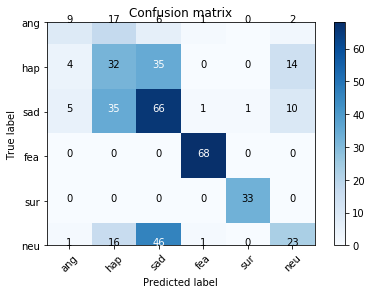

In [14]:
# Load predicted probabilities
# Load predicted probabilities
with open('/home/rashmi/BE Project/pre-processed/pred_probas/rf_classifier.pkl', 'rb') as f:
    rf_pred_probs = pickle.load(f)

with open('/home/rashmi/BE Project/pre-processed/pred_probas/xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)
    
with open('/home/rashmi/BE Project/pre-processed/pred_probas/svc_classifier_model.pkl', 'rb') as f:
    svc_preds = pickle.load(f)
    
with open('/home/rashmi/BE Project/pre-processed/pred_probas/mnb_classifier.pkl', 'rb') as f:
    mnb_pred_probs = pickle.load(f)
    
with open('/home/rashmi/BE Project/pre-processed/pred_probas/mlp_classifier.pkl', 'rb') as f:
    mlp_pred_probs = pickle.load(f)
    
with open('/home/rashmi/BE Project/pre-processed/pred_probas/lr_classifier.pkl', 'rb') as f:
    lr_pred_probs = pickle.load(f)

#with open('/home/rashmi/BE Project/pre-processed/pred_probas/lstm_classifier.pkl', 'rb') as f:
  #  lstm_pred_probs = pickle.load(f)

# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs +
                       mlp_pred_probs +
                       rf_pred_probs)/3.0
print(ensemble_pred_probs)
# Show metrics
display_results(y_test, ensemble_pred_probs)

In [20]:
ensemble_pred_probs2 = (xgb_pred_probs +
                       svc_preds +
                       mnb_pred_probs)/3.0

# Show metrics
display_results(y_test, ensemble_pred_probs2)

TypeError: unsupported operand type(s) for +: 'float' and 'LinearSVC'

Test Set Accuracy =  0.559
Test Set F-score =  0.593
Test Set Precision =  0.633
Test Set Recall =  0.590
Confusion matrix, without normalization
[[11 15  7  0  0  2]
 [ 4 33 39  0  0  9]
 [ 5 29 76  0  0  8]
 [ 0  0  0 68  0  0]
 [ 0  0  0  0 33  0]
 [ 0 14 55  1  0 17]]


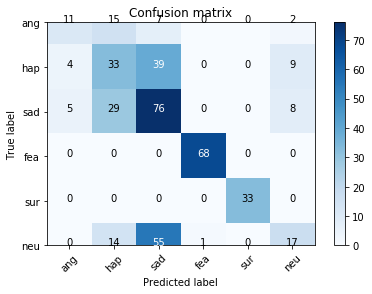

In [24]:
ensemble_pred_probs2 = (rf_pred_probs +
                       xgb_pred_probs +
                       lr_pred_probs)/3.0

display_results(y_test, ensemble_pred_probs2)

Test Set Accuracy =  0.498
Test Set F-score =  0.474
Test Set Precision =  0.610
Test Set Recall =  0.470
Confusion matrix, without normalization
[[ 7 10 16  1  0  1]
 [ 3 21 55  1  0  5]
 [ 0 18 93  2  1  4]
 [ 0  0  0 68  0  0]
 [ 0  0 16  0 17  0]
 [ 0 10 68  3  0  6]]


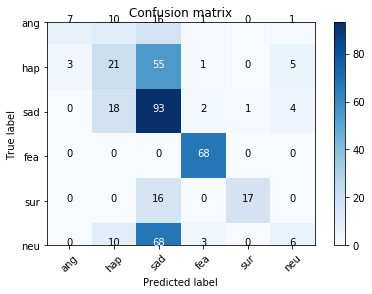

In [23]:
ensemble_pred_probs2 = (rf_pred_probs +
                       mnb_pred_probs +
                       mlp_pred_probs)/3.0

display_results(y_test, ensemble_pred_probs2)

Test Set Accuracy =  0.547
Test Set F-score =  0.541
Test Set Precision =  0.647
Test Set Recall =  0.557
Confusion matrix, without normalization
[[ 7 12 15  0  0  1]
 [ 3 21 57  0  0  4]
 [ 0 17 99  0  0  2]
 [ 0  0  0 68  0  0]
 [ 0  0  0  0 33  0]
 [ 0  6 75  1  0  5]]


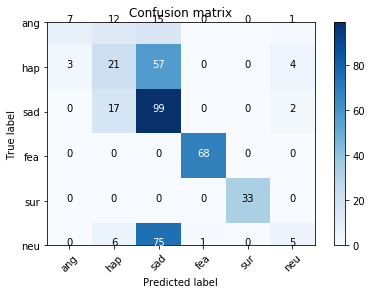

In [25]:
ensemble_pred_probs2 = (rf_pred_probs +
                       mnb_pred_probs +
                       lr_pred_probs)/3.0

display_results(y_test, ensemble_pred_probs2)

Test Set Accuracy =  0.519
Test Set F-score =  0.511
Test Set Precision =  0.628
Test Set Recall =  0.505
Confusion matrix, without normalization
[[ 8 12 13  1  0  1]
 [ 3 28 48  1  0  5]
 [ 0 22 89  2  1  4]
 [ 0  0  0 68  0  0]
 [ 0  0 12  0 21  0]
 [ 0 12 65  3  0  7]]


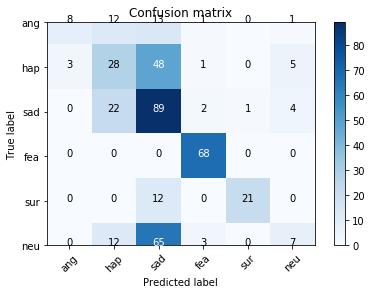

In [26]:
ensemble_pred_probs2 = (rf_pred_probs +
                       mlp_pred_probs +
                       lr_pred_probs)/3.0

display_results(y_test, ensemble_pred_probs2)

Test Set Accuracy =  0.554
Test Set F-score =  0.557
Test Set Precision =  0.623
Test Set Recall =  0.568
Confusion matrix, without normalization
[[ 7  9 17  1  0  1]
 [ 3 29 46  0  0  7]
 [ 3 19 90  1  0  5]
 [ 0  0  0 68  0  0]
 [ 0  0  0  0 33  0]
 [ 0  9 67  2  0  9]]


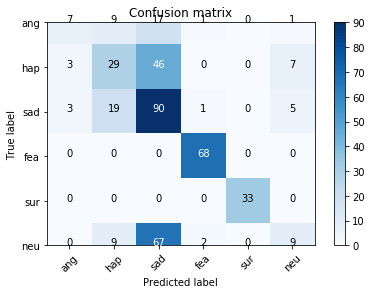

In [27]:
ensemble_pred_probs2 = (xgb_pred_probs +
                       mnb_pred_probs +
                       mlp_pred_probs)/3.0

display_results(y_test, ensemble_pred_probs2)

Test Set Accuracy =  0.554
Test Set F-score =  0.567
Test Set Precision =  0.637
Test Set Recall =  0.574
Confusion matrix, without normalization
[[ 9 13 10  1  0  2]
 [ 2 29 48  0  0  6]
 [ 3 22 89  0  0  4]
 [ 0  0  0 68  0  0]
 [ 0  0  0  0 33  0]
 [ 0 10 68  1  0  8]]


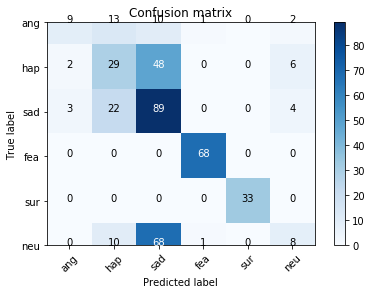

In [16]:
ensemble_pred_probs2 = (xgb_pred_probs +
                       mnb_pred_probs +
                       lr_pred_probs)/3.0

display_results(y_test, ensemble_pred_probs2)

Test Set Accuracy =  0.561
Test Set F-score =  0.577
Test Set Precision =  0.640
Test Set Recall =  0.583
Confusion matrix, without normalization
[[10 10 14  0  0  1]
 [ 3 31 44  0  0  7]
 [ 3 21 88  1  0  5]
 [ 0  0  0 68  0  0]
 [ 0  0  0  0 33  0]
 [ 0 10 66  2  0  9]]


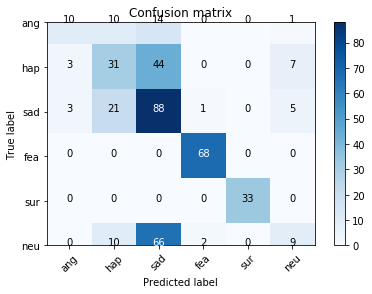

In [28]:
ensemble_pred_probs2 = (xgb_pred_probs +
                       mlp_pred_probs +
                       lr_pred_probs)/3.0

display_results(y_test, ensemble_pred_probs2)

Test Set Accuracy =  0.362
Test Set F-score =  0.247
Test Set Precision =  0.509
Test Set Recall =  0.275
Confusion matrix, without normalization
[[  6   7  21   1   0   0]
 [  3   8  72   2   0   0]
 [  0   7 111   0   0   0]
 [  0   0  40  28   0   0]
 [  0   0  31   1   1   0]
 [  0   3  79   5   0   0]]


/home/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


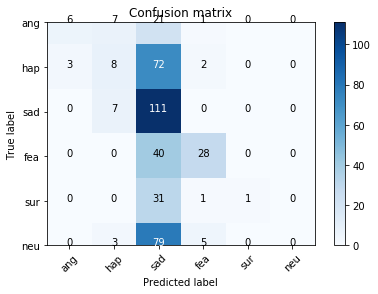

In [29]:
ensemble_pred_probs2 = (mnb_pred_probs +
                       mlp_pred_probs +
                       lr_pred_probs)/3.0

display_results(y_test, ensemble_pred_probs2)

Test Set Accuracy =  0.561
Test Set F-score =  0.586
Test Set Precision =  0.634
Test Set Recall =  0.584
Confusion matrix, without normalization
[[ 9 14  9  1  0  2]
 [ 4 32 40  0  0  9]
 [ 3 27 80  0  0  8]
 [ 0  0  0 68  0  0]
 [ 0  0  0  0 33  0]
 [ 0 15 54  1  0 17]]


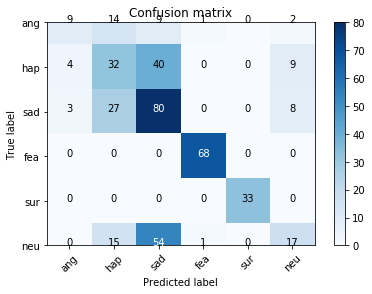

In [15]:
ensemble_pred_probs2 = (rf_pred_probs +
                       xgb_pred_probs +
                       mnb_pred_probs)/3.0

display_results(y_test, ensemble_pred_probs2)